# Decision Trees and Ensemble Learning

## Credit risk scoring project

**Dataset**

In [1]:
!wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv --quiet

### Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('ggplot')

**Data cleanining**

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# make all columns in lower
df.columns = df.columns.str.lower()

In [5]:
df.shape

(4455, 14)

**Mapping the target**

In [6]:
df['status'].value_counts(dropna=False)

1    3200
2    1254
0       1
Name: status, dtype: int64

In [7]:
df['status'] = df['status'].map({
    1:'ok',
    2:'default',
    0:'unk'
})

** Mapping categorical features **

In [8]:
def mapping_categorical(df, cat, cat_lst):
  to_lst = df[cat].value_counts().sort_index().index.to_list()
  cat_lst = cat_lst

  df[cat] = (
      df[cat].map({
          k:v for (k,v) in zip(to_lst, cat_lst)
      })
   )

In [9]:
cols = ['home', 'marital', 'records', 'job']

home_lst = ['unk', 'rent', 'owner', 'private', 'ignore', 'parents', 'other']
marital_lst = ['unk', 'single', 'married', 'widow', 'separated', 'divorced']
records_lst = ['no', 'yes', 'unk']
job_lst = ['unk', 'fixed', 'partime', 'freelance', 'others']
cat_lst = [home_lst, marital_lst, records_lst, job_lst]

for col, cat in zip(cols, cat_lst):
  mapping_categorical(df, col, cat)


In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


**Check numerical values**

In [11]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4455.0,763317.0,8703625.0,0.0,80.0,120.0,166.0,99999999.0
assets,4455.0,1060341.0,10217569.0,0.0,0.0,3500.0,6000.0,99999999.0
debt,4455.0,404382.0,6344253.0,0.0,0.0,0.0,0.0,99999999.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


One thing we immediately can notice is that the max value is 99999999 in some cases. This is quite suspicious. As it turns out, it’s an artificial value — this is how missing values are encoded in this dataset.

In [12]:
def fix_missing_values(df, val_to_rep, rep, *f_lst):
  for f in f_lst:
    df[f] = df[f].replace(val_to_rep, rep)

In [13]:
fix_missing_values(df, 99999999.0, np.nan, ['income', 'assets', 'debt'])

In [14]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4421.0,131.0,86.0,0.0,80.0,120.0,165.0,959.0
assets,4408.0,5403.0,11573.0,0.0,0.0,3000.0,6000.0,300000.0
debt,4437.0,343.0,1246.0,0.0,0.0,0.0,0.0,30000.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [15]:
df.isna().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

We notice that there’s one row with “unknown” status: we don’t know whether this client
managed to pay back the loan or not. For our project, this row is not useful

In [16]:
df = df[df.status != 'unk']

# Dataset preparation

Separate target from features. Since our objective is to determine if somebody fails to pay back their credit, the positive class is “default”. This means that y is “1” if the client defaulted and
“0” otherwise.

In [17]:
data, target = df.drop(columns=['status']), df['status'].map({'ok':0, 'default':1})

In [18]:
target.head()

0    0
1    0
2    1
3    0
4    0
Name: status, dtype: int64

**Spliting data**

**impute missing values and make pipelines**

In [19]:
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import (
    make_column_selector as selector, 
    ColumnTransformer, 
    make_column_transformer,
)    
from sklearn.pipeline import Pipeline, make_pipeline

In [20]:
X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
      data,
      target,
      test_size=.2,
      random_state=11,
    )
X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
      X_full_train,
      y_full_train,
      test_size=.25,
      random_state=11,
    )

In [21]:
def tweaking(data, target, pipeline=False, origin=False):
  X = data.copy()

  numerical = selector(dtype_include=np.number)(data)
  categorical = selector(dtype_include=object)(data)

  num_imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
  cat_imputer = SimpleImputer(strategy='most_frequent', fill_value='unk')
  cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
  
  if pipeline:
    cat_preprocessor = Pipeline([
      ('category_imputer', cat_imputer),
      ('category_encoder', cat_encoder)
    ])
    
    processor = ColumnTransformer([
      ('numeric', num_imputer, numerical),
      ('category', cat_preprocessor, categorical)
    ])
    
    return processor

  elif origin:
    X.loc[:, numerical] = num_imputer.fit_transform(X[numerical])
    X.loc[:, categorical] = cat_imputer.fit_transform(X[categorical])
    X.loc[:, categorical] = cat_encoder.fit_transform(X[categorical])

    return X

  else:
    X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
      data,
      target,
      test_size=.2,
      random_state=11,
    )
    X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
          X_full_train,
          y_full_train,
          test_size=.25,
          random_state=11,
        )


    X_train.loc[:, numerical] = num_imputer.fit_transform(X_train[numerical])
    X_train.loc[:, categorical] = cat_imputer.fit_transform(X_train[categorical])
    X_train.loc[:, categorical] = cat_encoder.fit_transform(X_train[categorical])

    X_dev.loc[:, numerical] = num_imputer.transform(X_dev[numerical])
    X_dev.loc[:, categorical] = cat_imputer.transform(X_dev[categorical])
    X_dev.loc[:, categorical] = cat_encoder.transform(X_dev[categorical])

    X_test.loc[:, numerical] = num_imputer.transform(X_test[numerical])
    X_test.loc[:, categorical] = cat_imputer.transform(X_test[categorical])
    X_test.loc[:, categorical] = cat_encoder.transform(X_test[categorical])

    return X_train, y_train, X_dev, y_dev, X_test, y_test

# Models

## Decision Trees

In [22]:
from sklearn.tree import DecisionTreeClassifier


processor = tweaking(data, target, pipeline=True)
# X_train, y_train, X_dev, y_dev, X_test, y_test = tweaking(data, target)

dt = make_pipeline(processor, DecisionTreeClassifier())
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['seniority', 'time', 'age',
                                                   'expenses', 'income',
                                                   'assets', 'debt', 'amount',
                                                   'price']),
                                                 ('category',
                                                  Pipeline(steps=[('category_imputer',
                                                                   SimpleImputer(fill_value='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('category_encoder',


In [23]:
from sklearn import metrics

y_pred = dt.predict_proba(X_train)[:, 1]
metrics.roc_auc_score(y_train, y_pred)

1.0

In [24]:
y_pred = dt.predict_proba(X_dev)[:, 1]
metrics.roc_auc_score(y_dev, y_pred)

0.6554576057736553

In [25]:
metrics.recall_score(y_dev, y_pred)

0.4828897338403042

We just observed a case of overfitting. The tree learned the training data so well that it simply memorized the outcome for each customer. However, when we applied it to the validation set, the model failed. The rules it extracted from data turned out too specific to the training set, so it worked poorly for customers it didn’t see during training. In such cases, we say that the model cannot generalize. Overfitting happens when we have a complex model with enough power to remember all the training data. If we force the model to be simpler, we can make it less powerful, and improve the model’s ability to generalize. There are multiple ways of controlling the complexity of a tree. One of the options is restricting its size: we can specify the max_depth parameter, which controls the maximal number of levels. The more levels a tree has, the more complex rules it can learn.

The default value for the `max_depth` parameter is `None`, which means that the tree can grow
as large as possible. We can try a smaller value and compare the results.

In [26]:
max_depth = 2

dt = make_pipeline(processor, DecisionTreeClassifier(max_depth=max_depth))
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['seniority', 'time', 'age',
                                                   'expenses', 'income',
                                                   'assets', 'debt', 'amount',
                                                   'price']),
                                                 ('category',
                                                  Pipeline(steps=[('category_imputer',
                                                                   SimpleImputer(fill_value='unk',
                                                                                 strategy='most_frequent')),
                                                                  ('category_encoder',


In [27]:
from sklearn.tree import export_text


tree_text = export_text(dt[1])
print(tree_text)

|--- feature_11 <= 0.50
|   |--- feature_12 <= 2.50
|   |   |--- class: 0
|   |--- feature_12 >  2.50
|   |   |--- class: 1
|--- feature_11 >  0.50
|   |--- feature_0 <= 6.50
|   |   |--- class: 1
|   |--- feature_0 >  6.50
|   |   |--- class: 0



In [28]:
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"AUC train set: {metrics.roc_auc_score(y_train, y_pred)}")

AUC train set: 0.7061968339811842


In [29]:
y_pred = dt.predict_proba(X_dev)[:, 1]
print(f"AUC dev set: {metrics.roc_auc_score(y_dev, y_pred)}")

AUC dev set: 0.6685264343319367


In [30]:
y_pred_rec = dt.predict(X_dev)
print(f"Recall dev set: {metrics.recall_score(y_dev, y_pred_rec)}")

Recall dev set: 0.38022813688212925


In [31]:
auc = []

for depth in [5, 8, 15, 25, 30, None]:
  dt = make_pipeline(processor, DecisionTreeClassifier(max_depth=depth))
  dt.fit(X_train, y_train)
  preds = dt.predict_proba(X_dev)[:, 1]
  score = metrics.roc_auc_score(y_dev, preds)
  auc.append((depth, score))
  # print(f"max_depth: {depth} ---> auc: {score}")

for depth, score in auc:
  print(f"max_depth: {depth} ---> auc: {score:.3f}")

max_depth: 5 ---> auc: 0.767
max_depth: 8 ---> auc: 0.728
max_depth: 15 ---> auc: 0.657
max_depth: 25 ---> auc: 0.651
max_depth: 30 ---> auc: 0.658
max_depth: None ---> auc: 0.648


In [32]:
for i in dt.get_params().keys():
  print(i)

memory
steps
verbose
columntransformer
decisiontreeclassifier
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__verbose_feature_names_out
columntransformer__numeric
columntransformer__category
columntransformer__numeric__add_indicator
columntransformer__numeric__copy
columntransformer__numeric__fill_value
columntransformer__numeric__missing_values
columntransformer__numeric__strategy
columntransformer__numeric__verbose
columntransformer__category__memory
columntransformer__category__steps
columntransformer__category__verbose
columntransformer__category__category_imputer
columntransformer__category__category_encoder
columntransformer__category__category_imputer__add_indicator
columntransformer__category__category_imputer__copy
columntransformer__category__category_imputer__fill_value
columntransformer__category__category_imputer__m

In [33]:
auc = []

for min_leaf in [1, 5, 10, 15, 20, 50, 100, 200]:
  for depth in [5, 8, 15, 25, 30, None]:
    dt.set_params(
        decisiontreeclassifier__min_samples_leaf=min_leaf, 
        decisiontreeclassifier__max_depth=depth
    )
    dt.fit(X_train, y_train)
    preds = dt.predict_proba(X_dev)[:, 1]
    res = metrics.roc_auc_score(y_dev, preds)
    auc.append((min_leaf, depth, res))

for min_leaf, depth, score in auc:
  print(f"min samples leaf: {min_leaf}, max_depth: {depth} ---> AUC: {score:.3f}")

min samples leaf: 1, max_depth: 5 ---> AUC: 0.767
min samples leaf: 1, max_depth: 8 ---> AUC: 0.733
min samples leaf: 1, max_depth: 15 ---> AUC: 0.663
min samples leaf: 1, max_depth: 25 ---> AUC: 0.644
min samples leaf: 1, max_depth: 30 ---> AUC: 0.650
min samples leaf: 1, max_depth: None ---> AUC: 0.648
min samples leaf: 5, max_depth: 5 ---> AUC: 0.768
min samples leaf: 5, max_depth: 8 ---> AUC: 0.747
min samples leaf: 5, max_depth: 15 ---> AUC: 0.711
min samples leaf: 5, max_depth: 25 ---> AUC: 0.717
min samples leaf: 5, max_depth: 30 ---> AUC: 0.719
min samples leaf: 5, max_depth: None ---> AUC: 0.715
min samples leaf: 10, max_depth: 5 ---> AUC: 0.767
min samples leaf: 10, max_depth: 8 ---> AUC: 0.766
min samples leaf: 10, max_depth: 15 ---> AUC: 0.761
min samples leaf: 10, max_depth: 25 ---> AUC: 0.764
min samples leaf: 10, max_depth: 30 ---> AUC: 0.765
min samples leaf: 10, max_depth: None ---> AUC: 0.762
min samples leaf: 15, max_depth: 5 ---> AUC: 0.773
min samples leaf: 15, max

In [34]:
sorted(auc, key=lambda x: x[-1], reverse=True)

[(15, 30, 0.790311448015306),
 (15, 25, 0.7902842023685549),
 (15, 15, 0.7889007289724154),
 (15, None, 0.7888250466203289),
 (20, 25, 0.7822649003414788),
 (15, 8, 0.7817048509360393),
 (20, 30, 0.7812447022353539),
 (20, 15, 0.7805484245961589),
 (20, None, 0.7805030151849071),
 (100, 15, 0.779812792133879),
 (100, 25, 0.779812792133879),
 (100, None, 0.779812792133879),
 (100, 8, 0.7795615267249522),
 (100, 30, 0.7795615267249522),
 (50, 8, 0.7791467874355187),
 (20, 8, 0.7787199389697513),
 (50, 15, 0.7748268387784263),
 (50, 30, 0.7748268387784263),
 (50, None, 0.7748268387784263),
 (20, 5, 0.7735372114988738),
 (50, 25, 0.7733828195006176),
 (15, 5, 0.7727228693904241),
 (200, 8, 0.7684786030854182),
 (200, 15, 0.7684786030854182),
 (200, 25, 0.7684786030854182),
 (200, 30, 0.7684786030854182),
 (200, None, 0.7684786030854182),
 (5, 5, 0.7677702162698894),
 (10, 5, 0.7672949310987867),
 (1, 5, 0.7669528468673561),
 (50, 5, 0.7665108619311714),
 (10, 8, 0.7655239640599647),
 (10, 

The best AUC is 79.15% with parameters min_sample_leaf=15 and
max_depth=15

In [35]:
dt.set_params(
        decisiontreeclassifier__min_samples_leaf=15, 
        decisiontreeclassifier__max_depth=15
    )
dt.fit(X_train, y_train)

preds = dt.predict_proba(X_dev)[:, 1]
pred_r = dt.predict(X_dev)

print(f"AUC:{metrics.roc_auc_score(y_dev, preds)}")
print(f"Recall:{metrics.recall_score(y_dev, pred_r)}")

AUC:0.7909774527136665
Recall:0.49429657794676807


In [36]:
!pip install optuna --quiet

     |████████████████████████████████| 348 kB 5.8 MB/s 
     |████████████████████████████████| 209 kB 9.8 MB/s 
     |████████████████████████████████| 81 kB 4.4 MB/s 
     |████████████████████████████████| 78 kB 5.2 MB/s 
     |████████████████████████████████| 112 kB 7.9 MB/s 
     |████████████████████████████████| 147 kB 11.1 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 


In [37]:
import optuna
from functools import partial


def optimize(trial, x, y):
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  # min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
  max_features = trial.suggest_categorical("max_features", ["log2", "sqrt", None])

  model = DecisionTreeClassifier(
      min_samples_leaf=min_samples_leaf, 
      max_depth=max_depth,
      # min_samples_split=min_samples_split,
      max_features=max_features,
  )

  kf = model_selection.KFold(n_splits=5)
  auc = []

  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    model.fit(xtrain, ytrain)

    preds = model.predict_proba(xdev)[:, 1]
    fold_accuracy = metrics.roc_auc_score(ydev, preds)
    auc.append(fold_accuracy)

    return -1 * np.mean(auc)

X = tweaking(data, target, origin=True)
optimization_function = partial(optimize,x=X.values, y=target.values)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=50)

[I 2022-10-13 08:36:34,247] A new study created in memory with name: no-name-f7139352-d50d-4e28-be50-2e9873046e9e
[I 2022-10-13 08:36:34,268] Trial 0 finished with value: -0.7695727277345933 and parameters: {'min_samples_leaf': 24, 'max_depth': 30, 'max_features': 'log2'}. Best is trial 0 with value: -0.7695727277345933.
[I 2022-10-13 08:36:34,327] Trial 1 finished with value: -0.7778444596860234 and parameters: {'min_samples_leaf': 9, 'max_depth': 29, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.7778444596860234.
[I 2022-10-13 08:36:34,348] Trial 2 finished with value: -0.797702967027384 and parameters: {'min_samples_leaf': 117, 'max_depth': 21, 'max_features': 'log2'}. Best is trial 2 with value: -0.797702967027384.
[I 2022-10-13 08:36:34,377] Trial 3 finished with value: -0.7493966874968246 and parameters: {'min_samples_leaf': 134, 'max_depth': 24, 'max_features': 'sqrt'}. Best is trial 2 with value: -0.797702967027384.
[I 2022-10-13 08:36:34,399] Trial 4 finished with va

In [38]:
#81.923, 82.278 83.18

dt = make_pipeline(processor, DecisionTreeClassifier(
    min_samples_leaf=52, 
    max_depth=17,  
    max_features=None
))

X_train, y_train, X_dev, y_dev, X_test, y_test = tweaking(data, target)

dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_dev)[:,1]
pred_r = dt.predict(X_dev)

print(f"AUC: {metrics.roc_auc_score(y_dev, y_pred):.3f}")
print(f"Recall: {metrics.recall_score(y_dev, pred_r):.3f}")

AUC: 0.776
Recall: 0.498


In [39]:
X_train.isna().sum()

seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=3)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_dev)[:, 1]

metrics.roc_auc_score(y_dev, y_pred)

0.7734312562059529

The number of trees in the ensemble is an important parameter and it influences the
performance of the model. Usually, a model with more trees is better than a model with fewer
trees. On the other hand, adding too many trees is not always helpful.

n_estimator:120 >> score:0.820
n_estimator:300 >> score:0.822
n_estimator:500 >> score:0.823
n_estimator:800 >> score:0.825
n_estimator:1200 >> score:0.826


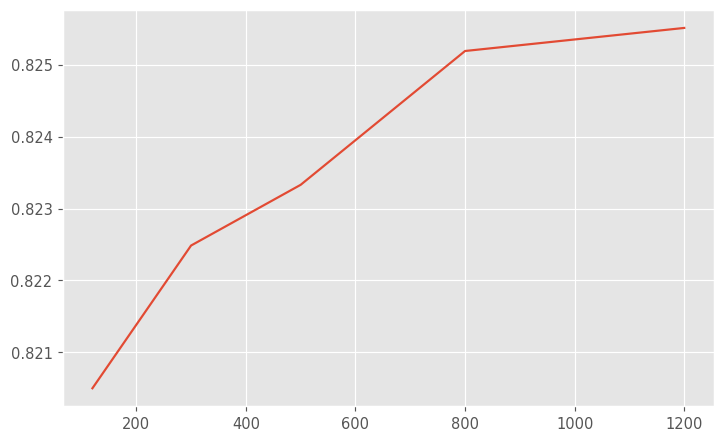

In [41]:
auc = []
for i in [120, 300, 500, 800, 1200]:
  rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=3)
  rf.fit(X_train, y_train)
  y_pred = rf.predict_proba(X_dev)[:, 1]
  score = metrics.roc_auc_score(y_dev, y_pred)
  auc.append(score)
  print(f"n_estimator:{i} >> score:{score:.3f}")

plt.figure(figsize=(8, 5), dpi=105)
plt.plot([120, 300, 500, 800, 1200], auc)
plt.show();

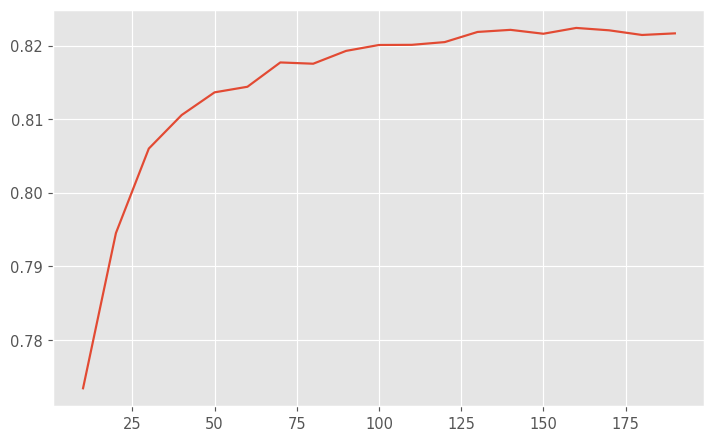

In [42]:
auc = []
for i in range(10, 200, 10):
  rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=3)
  rf.fit(X_train, y_train)
  y_pred = rf.predict_proba(X_dev)[:, 1]
  score = metrics.roc_auc_score(y_dev, y_pred)
  auc.append(score)
  # print(f"n_estimator:{i} >> score:{score}")

plt.figure(figsize=(8, 5), dpi=105)
plt.plot(range(10, 200, 10), auc)
plt.show();

## Parameter tuning for random forest

In [43]:
def optimize(trial, x, y):
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 200)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  n_estimators = trial.suggest_int("n_estimators", 10, 200)
  criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

  model = RandomForestClassifier(
      min_samples_leaf=min_samples_leaf, 
      max_depth=max_depth,
      n_estimators=n_estimators,
      criterion=criterion,
  )

  kf = model_selection.KFold(n_splits=5)
  auc = []

  for idx in kf.split(X=x, y=y):
    train_idx, dev_idx = idx[0], idx[1]
    xtrain = x[train_idx]
    ytrain = y[train_idx]

    xdev = x[dev_idx]
    ydev = y[dev_idx]

    model.fit(xtrain, ytrain)

    preds = model.predict_proba(xdev)[:, 1]
    fold_accuracy = metrics.roc_auc_score(ydev, preds)
    auc.append(fold_accuracy)

    return -1 * np.mean(auc)

optimization_function = partial(optimize,x=X.values, y=target.values)
study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=50)

[I 2022-10-13 08:37:11,929] A new study created in memory with name: no-name-b7d68d11-ef16-4cff-ae5b-54d311779e3d
[I 2022-10-13 08:37:12,017] Trial 0 finished with value: -0.8398141797490221 and parameters: {'min_samples_leaf': 67, 'max_depth': 24, 'n_estimators': 24, 'criterion': 'gini'}. Best is trial 0 with value: -0.8398141797490221.
[I 2022-10-13 08:37:12,470] Trial 1 finished with value: -0.8413383376517807 and parameters: {'min_samples_leaf': 182, 'max_depth': 9, 'n_estimators': 154, 'criterion': 'entropy'}. Best is trial 1 with value: -0.8413383376517807.
[I 2022-10-13 08:37:12,608] Trial 2 finished with value: -0.8386393080323121 and parameters: {'min_samples_leaf': 138, 'max_depth': 15, 'n_estimators': 43, 'criterion': 'gini'}. Best is trial 1 with value: -0.8413383376517807.
[I 2022-10-13 08:37:12,790] Trial 3 finished with value: -0.8451169791190367 and parameters: {'min_samples_leaf': 81, 'max_depth': 22, 'n_estimators': 48, 'criterion': 'entropy'}. Best is trial 3 with va

In [44]:
# {'min_samples_leaf': 2, 'max_depth': 9, 'n_estimators': 55, 'criterion': 'entropy'}
rf = RandomForestClassifier(
    n_estimators=55,
    criterion="entropy",
    max_depth=9,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=3
)

rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_dev)[:, 1]
metrics.roc_auc_score(y_dev, y_pred)

0.8246379356276186

## Gradient boosting

In a random forest, each tree is independent: it’s trained on a different set of features. After individual trees are trained, we combine all their decisions together to get the final decision. It’s not the only way to combine multiple models together in one ensemble. Alternatively, we can train models sequentially: each next model tries to fix errors from the previous one:
* Train the first model.
* Look at the errors it makes.
* Train another model that fixes these errors.
* Look at the errors again, repeat sequentially.  

This way of combining models is called boosting. Gradient boosting is a particular variation of this approach that works especially well with trees.

## XGBoost: extreme gradient boosting

In [47]:
import xgboost as xgb 

# wrap data into DMatrix — a special
# data structure for finding splits efficiently.
dtrain = xgb.DMatrix(
    X_train.values, 
    label=y_train.values, 
    feature_names=X_train.columns
)

# for validation
dval = xgb.DMatrix(
    X_dev.values,
    label=y_dev.values,
    feature_names=X_dev.columns
)

# specifying the parameters for training
xgb_params = {
    'eta':.3,
    'max_depth':6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent':1
}

# For training an XGBoost model, we use the train function
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=10
)

In [48]:
# Evaluate the model with predict function
y_pred = model.predict(dval)
y_pred[:10]

array([0.06651721, 0.08702892, 0.16599497, 0.17462038, 0.06536325,
       0.08394843, 0.07825396, 0.65124536, 0.45046538, 0.03558019],
      dtype=float32)

In [49]:
metrics.roc_auc_score(y_dev, y_pred)

0.8121897023564457

### Model performance monitoring

To get an idea how `AUC` changes as the number of trees **grows**, we can use a *watchlist* built-in feature in `XGBoost` for monitoring model performance.

In [51]:
watchlist = [(dtrain, 'train'), (dval, 'dev')]

# Additionally, we’ll modify the list of parameters for training: 
# we need to specify the metric we
# use for evaluation. In our case, it’s AUC

xgb_params = {
    'eta':.3,
    'max_depth':6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent':1
}

# To use the watchlist during training, we need to specify two extra 
# arguments for the train function:
#   - evals — the watchlist.
#   - verbose_eval — how often we print the metric. 
#     If we put “10”, we’ll see the result after each 10th step.

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=10
)

[0]	train-auc:0.863973	dev-auc:0.766608
[10]	train-auc:0.955016	dev-auc:0.812099
[20]	train-auc:0.977688	dev-auc:0.817518
[30]	train-auc:0.988884	dev-auc:0.813667
[40]	train-auc:0.993779	dev-auc:0.814085
[50]	train-auc:0.997623	dev-auc:0.813782
[60]	train-auc:0.999038	dev-auc:0.811966
[70]	train-auc:0.999658	dev-auc:0.812105
[80]	train-auc:0.999951	dev-auc:0.811064
[90]	train-auc:0.999996	dev-auc:0.80886
[99]	train-auc:1	dev-auc:0.806698
